# Decision Trees

<img src="img/tree.jpeg" width=200>

## Outcomes

- summarize the intuitive logic behind decision trees
- solve a small example with metric
- explore the fine-tuning options in `sklearn` for decision trees
- build a decision tree in `sklearn`


The key tool of decision trees is that some attributes provide more _information_ than others when trying to make a decision.<br>
And we rank attributes in the hierarchy based on how useful they are.

### Example 1 - when looking to monogamously date someone
Which is more important?

Their taste in music?
![music](img/music.png)

Or if they are married already?
![married2](img/married2.png)

### Example 2 - when looking for someone to pet sit your cat
Which is more important?

How many cats **they** have:

![cats](img/cats.gif)

How many cats have **died** on their watch while pet sitting:

![petcem](img/petcem.gif)

### Example 3 with some vocab
Rory is a teenager trying to decide if he wants to go to a party, and this is the decision tree represtinging his process:

#### His decision tree
<img src="img/party.png" width=500>

### Vocabulary: nodes

<img src="img/terminology1.png" width=500>

### Vocabulary: splits & branches

<img src="img/terminology2.png" width=500>

### Example 4: with data

Suppose we're working on a classification algorithm designed to **sort customers into two classes: those who pay their sales bills and those who don't**.

Each row in my dataframe represents a customer, and I have many predictors (columns) in my dataframe, including:

- salary
- total_bill
- club_member (boolean)
- years_post-sec_ed

Let's look at a simple set of data. **The 'paid' column is our target or dependent variable.**

In [1]:
import pandas as pd
custs = pd.DataFrame([[45000, 1000, True, 2, False],
                      [70000, 100, True, 10, True],
                      [30000, 2000, False, 0, False],
                      [90000, 500, True, 2, True],
                      [70000, 200, True, 5, False]],
                     columns=['salary', 'total_bill', 'club_member', 'years_post-sec_ed', 'paid'])

In [2]:
custs

,salary,total_bill,club_member,years_post-sec_ed,paid
0,45000,1000,True,2,False
1,70000,100,True,10,True
2,30000,2000,False,0,False
3,90000,500,True,2,True
4,70000,200,True,5,False


## Partitioning

I partition my data by asking a question about the independent variables. The goal is to ask the right questions in the right order so that the resultant groups are "pure" with respect to the dependent variable. More on this below!


### Let's explore some variables below:

In [3]:
test = custs.sort_values(['salary'])
test

,salary,total_bill,club_member,years_post-sec_ed,paid
2,30000,2000,False,0,False
0,45000,1000,True,2,False
1,70000,100,True,10,True
4,70000,200,True,5,False
3,90000,500,True,2,True


### Is the customer a club member?

This would divide my data into two groups:

- Group 1:

data points: 0, 1, 3, 4 (dep. var.: False, True, True, False)

- Group 2:

data points: 2 (dep. var.: False)

While I've isolated one of the customers who haven't paid in the second group, the first group is an even mix of payers and non-payers. So this split is not particularly good.

Would a different question split our data more effectively? Let's try:

### "Is the customer's salary less than $60k?"

This would divide my data into two groups:

- Group 1:

data points: 0, 2 (dep. var.: False, False)

-  Group 2:

data points: 1, 3, 4 (dep. var.: True, True, False)

## Which feature is more accurate in predicting whether and individual pays their bill?

## Entropy and Information Gain

The goal is to have our ultimate classes be fully "ordered" (for a binary dependent variable, we'd have the 1's in one group and the 0's in the other). So one way to assess the value of a split is to measure how *disordered* our groups are, and there is a notion of *entropy* that measures precisely this.

The entropy of the whole dataset is given by:

$\large E = -\Sigma_i p_i\log_2(p_i)$,

where $p_i$ is the probability of belonging to the $i$th group.

**Entropy will always be between 0 and 1. The closer to 1, the more disordered your group.**

To repeat, in the present case we have only two groups of interest: the payers (2/5) and the non-payers (3/5).

So our entropy for this toy dataset is:

$-0.4*\log_2(0.4) -0.6*\log_2(0.6)$.

Let's use the ```math``` library to calculate this:

In [4]:
import math
-.4*math.log(.4,2)-.6*math.log(.6,2)

0.9709505944546686

In [5]:
# example: perfectly even split

-.5*math.log(.5,2)-.5*math.log(.5,2)

1.0

To calculate the entropy of a *split*, we're going to want to calculate the entropy of each of the groups made by the split, and then calculate a weighted average of those groups' entropies––weighted, that is, by the size of the groups. Let's calculate the entropy of the split produced by our question above about salary:

Group 1:

$E_{g1} = 0 * \log_2(0) - 1 * \log_2(1) = 0$. This is a pure group! The probability of being a payer in Group 1 is 0 and the probability of being a non-payer in Group 1 is 1.

Group 2:

$E_{g2} = -\frac{2}{3} * \log_2\left(\frac{2}{3}\right) - \frac{1}{3} * \log_2\left(\frac{1}{3}\right)$.

Once again, using ```math```:

In [6]:
-1*math.log(1,2)

-0.0

In [7]:
-2/3 * math.log(2/3,2) - 1/3 * math.log(1/3,2)

0.9182958340544896

to get the whole entropy of this split, we'll do a weighted sum of the two group entropies:

In [8]:
0 * 2/5 + .9183 * 3/5

0.55098

In [9]:
# for "is a club member?"
0 * 1/5 + 1 * 4/5

0.8

For a given split, the **information gain** is simply the entropy of the parent group less the entropy of the split.

For a given parent, then, we maximize our model's performance by *minimizing* the split's entropy.

What we'd like to do then is:

1. to look at the entropies of all possible splits, and
2. to choose the split with the lowest entropy.

In practice there are far too many splits for it to be practical for a person to calculate all these different entropies ...

... but we can make computers do these calculations for us!

## Gini Impurity

An alternative metric to entropy comes from the work of Corrado Gini. The Gini Impurity is defined as:

$\large G = 1 - \Sigma_i p_i^2$,

where, again, $p_i$ is the probability of belonging to the $i$th group.

**Gini Impurity will always be between 0 and 0.5. The closer to 0.5, the more disordered your group.**

Exercise: Calculate the Gini Impurity for our toy dataset above.

In [10]:
1 - (.4**2 + .6**2)

0.48

In [11]:
# perfectly disordered, even case
1-(.5**2 + .5**2)

0.5

## Coding Trees in Python

Scikit-learn has a tree module, which houses both a DecisionTreeClassifier and a DecisionTreeRegressor. The difference, as is probably clear by now, is that the former is for classification problems (discrete target) and the latter is for regression problems (continuous target). Let's use the classifier.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [13]:
custs

,salary,total_bill,club_member,years_post-sec_ed,paid
0,45000,1000,True,2,False
1,70000,100,True,10,True
2,30000,2000,False,0,False
3,90000,500,True,2,True
4,70000,200,True,5,False


In [21]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(custs.drop(columns = 'paid'), custs.paid)

DecisionTreeClassifier(max_depth=2)

In [22]:
dt.score(custs.drop(columns='paid'),custs.paid)

0.8

In [23]:
dt.feature_importances_

array([0.23809524, 0.76190476, 0.        , 0.        ])

In [24]:
dt.tree_

## Visualizing Trees in Python

[Text(200.88000000000002, 181.2, 'total_bill <= 750.0\ngini = 0.48\nsamples = 5\nvalue = [3, 2]\nclass = Unpaid'),
 Text(133.92000000000002, 108.72, 'salary <= 80000.0\ngini = 0.444\nsamples = 3\nvalue = [1, 2]\nclass = Paid'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = Unpaid'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Paid'),
 Text(267.84000000000003, 108.72, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = Unpaid')]

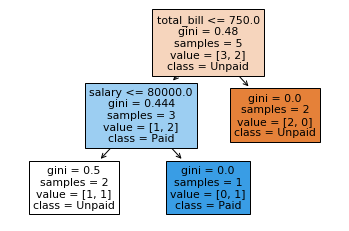

In [29]:
from sklearn import tree

tree.plot_tree(dt, feature_names = list(custs.columns)[:-1], filled = True, class_names = ['Unpaid','Paid'])

In [30]:
print(tree.export_graphviz(dt, feature_names = list(custs.columns)[:-1], filled = True, class_names = ['Unpaid','Paid']))

# copy the copy below to http://www.webgraphviz.com/ to generate visualization

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="total_bill <= 750.0\ngini = 0.48\nsamples = 5\nvalue = [3, 2]\nclass = Unpaid", fillcolor="#f6d5bd"] ;
1 [label="salary <= 80000.0\ngini = 0.444\nsamples = 3\nvalue = [1, 2]\nclass = Paid", fillcolor="#9ccef2"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = Unpaid", fillcolor="#ffffff"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Paid", fillcolor="#399de5"] ;
1 -> 3 ;
4 [label="gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = Unpaid", fillcolor="#e58139"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}


### Evaluating a decision tree:
- Train and test - use predict to compare auc of test and train
- "prune" the tree: adjust minimum number of samples required at a leaf node or a split as well as setting the maximum depth of the tree.


### Pros and Cons of Decision Trees

#### Pros:
- Easy to Understand
- Useful in Data exploration
- Less data cleaning required
- Data type is not a constraint
- Non Parametric Method

#### Cons:
- Prone to over-fitting
- Struggles with creating cut-off splits with continuous variables
- Non Parametric Method


### Extra Practice

In [31]:
# Breast Cancer identification dataset
import pandas as pd

df = pd.read_csv('data/breast_cancer.csv', index_col=0)
df = df.drop(columns=['Unnamed: 32'])
df['Target'] = df.diagnosis.map(lambda x: 1 if x == 'M' else 0)
df = df.drop(columns='diagnosis')

In [32]:
df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Target
id,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1


In [35]:
from sklearn.model_selection import train_test_split

In [49]:
X = df.drop(columns='Target')
y = df.Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
dt = DecisionTreeClassifier()
dt.fit(df.drop(columns = 'Target'), df.Target)

DecisionTreeClassifier()

In [39]:
dt.score(X_train, y_train)

1.0

In [53]:
dt.score(X_test, y_test)

1.0

In [54]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.9428571428571428
0.9473684210526315


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


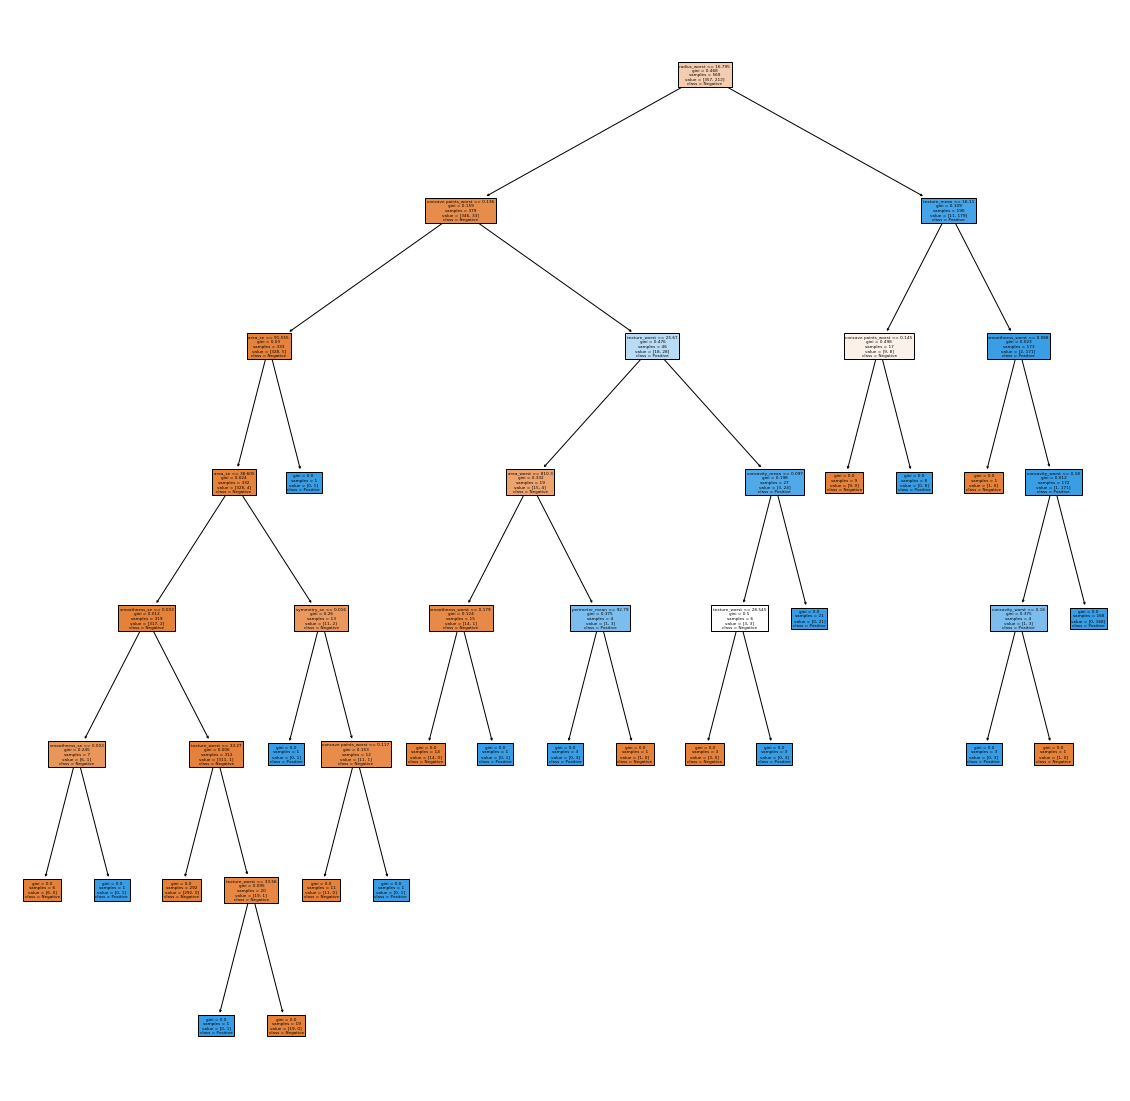

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,20))
tree.plot_tree(dt, feature_names = list(df.columns)[:-1], filled = True, class_names = ['Negative','Positive'])
plt.savefig('mytree.png')

In [52]:
print(tree.export_graphviz(dt, feature_names = list(df.columns)[:-1], filled = True, class_names = ['Negative','Positive']))


digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="radius_worst <= 16.795\ngini = 0.468\nsamples = 569\nvalue = [357, 212]\nclass = Negative", fillcolor="#f4ccaf"] ;
1 [label="concave points_worst <= 0.136\ngini = 0.159\nsamples = 379\nvalue = [346, 33]\nclass = Negative", fillcolor="#e78d4c"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="area_se <= 91.555\ngini = 0.03\nsamples = 333\nvalue = [328, 5]\nclass = Negative", fillcolor="#e5833c"] ;
1 -> 2 ;
3 [label="area_se <= 38.605\ngini = 0.024\nsamples = 332\nvalue = [328, 4]\nclass = Negative", fillcolor="#e5833b"] ;
2 -> 3 ;
4 [label="smoothness_se <= 0.003\ngini = 0.012\nsamples = 319\nvalue = [317, 2]\nclass = Negative", fillcolor="#e5823a"] ;
3 -> 4 ;
5 [label="smoothness_se <= 0.003\ngini = 0.245\nsamples = 7\nvalue = [6, 1]\nclass = Negative", fillcolor="#e9965a"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 6\nvalue = [6, 0]\nclass = Negative", fillcolor="#e58139"] ;
5 -> 6 ;
7 

copy the above code and paste in http://www.webgraphviz.com/ to generate visualization

In [42]:
pip install graphviz

  Using cached graphviz-0.14-py2.py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [57]:
conda install graphviz

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cairo-1.14.12              |       hc4e6be7_4         860 KB
    conda-4.8.3                |           py37_0         2.8 MB
    fontconfig-2.13.0          |       h5d5b041_1         202 KB
    fribidi-1.0.9              |       haf1e3a3_0          63 KB
    graphite2-1.3.13           |       h2098e52_0          80 KB
    graphviz-2.40.1            |       hefbbd9a_2         6.3 MB
    harfbuzz-1.8.8             |       hb8d4a28_0         414 KB
    pango-1.42.4               |       h7e27002_1         456 KB
    pixman-0.4

In [43]:
from sklearn.tree import export_graphviz
import graphviz
used_cols = [c for c in df.columns.to_list() if c not in ['Target']]
def plot_tree(dt, used_cols, out_file='mytree.dot'):
    export_graphviz(dt, out_file=out_file, filled=True, feature_names=used_cols, leaves_parallel=True, node_ids=True)
    with open(out_file) as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)
   

In [58]:
used_cols = [c for c in df.columns.to_list() if c not in ['Target']]
out_file='mytree.dot'
plot_tree(dt, used_cols, out_file)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

## Outcome Review

- summarize the intuitive logic behind decision trees
- solve a small example with metric
- explore the fine-tuning options in `sklearn` for decision trees
- build a decision tree in `sklearn`
